In [1]:
from collections import deque, namedtuple
from random import sample
import numpy as np
import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt 

/Users/labuser/miniconda3/envs/rl_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = gym.make('LunarLander-v2')

In [3]:
num_episodes = 3
for i in range(num_episodes):
    state = env.reset()
    Done = False
    total_rewards = 0
    
    while not Done: 
        #take a random action
        action = env.action_space.sample()
        #implement the action 
        next_state, reward, Done, info = env.step(action)
        #sum the rewards
        total_rewards += reward
        #render the env
        env.render()
    print("The episode total rewards is ", total_rewards)

env.close()

The episode total rewards is  -135.17469718325276
The episode total rewards is  -116.7741200625006
The episode total rewards is  -265.583606382973


In [51]:
state = env.reset()
state

array([-5.8755872e-04,  1.4036485e+00, -5.9532933e-02, -3.2317889e-01,
        6.8766251e-04,  1.3485086e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

In [3]:
class Deep_Q_Network(nn.Module):
    def __init__(self,num_states,num_actions,nodes_1 =50, nodes_2 = 50):
        super(Deep_Q_Network,self).__init__()
        self.fc1 = nn.Linear(num_states,nodes_1)
        self.fc2 = nn.Linear(nodes_1,nodes_2)
        self.fc3 = nn.Linear(nodes_2,num_actions)
    
    def forward(self,states):
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [4]:
model = Deep_Q_Network(8,4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
states = env.reset()
states = torch.from_numpy(states[np.newaxis,:]).to(device)
model(states).max()

tensor(0.1069, grad_fn=<MaxBackward1>)

In [42]:
# class MemoryReplay:
#     def __init__(self, max_size):
#         self.states = []
#         self.actions = []
#         self.rewards = []
#         self.next_states = []
#         self.Dones = []
#         self.max_size = max_size
#         self.idx = 0
#         self.size = 0

#     def append(self, state,action, reward,next_state,Done):
#         #first in, first out 
#         if self.idx <= self.max_size:
#             self.states.append(state)
#             self.actions.append(action)
#             self.rewards.append(reward)
#             self.next_states.append(next_state)
#             self.Dones.append(Done)
#         else:
#             #overwrite older values 
#             self.states[self.idx] = state
#             self.actions[self.idx]= action
#             self.rewards[self.idx] = reward
#             self.next_states[self.idx] =next_state
#             self.Dones[self.idx] = Done
#         self.size = min(self.size + 1, self.max_size)
#         self.idx = (self.idx + 1) % self.max_size

#     def sample(self, batch_size):
#         indices = sample(range(self.size), batch_size)
#         states = np.array(self.states)[indices]
#         actions =  np.array(self.actions)[indices]
#         rewards = np.array(self.rewards)[indices]
#         next_states = np.array(self.next_states)[indices]
#         Dones = np.array(self.Dones)[indices]
        
#         return states,actions, rewards, next_states, Dones
#     def __len__(self):
#         return self.size

In [5]:
class MemoryReplay:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    
    def append(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self,batch_size):
        """Randomly sample a batch of experiences from memory."""
        experiences = sample(self.memory, k=batch_size)

        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None]).squeeze(1)
        rewards = np.vstack([e.reward for e in experiences if e is not None]).squeeze(1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = np.vstack([e.done for e in experiences if e is not None]).squeeze(1)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## test Memory Replay 

In [6]:
m1 = MemoryReplay(10000)

num_episodes = 150
for i in range(num_episodes):
    state = env.reset()
    Done = False
    total_rewards = 0
    
    while not Done: 
        #take a random action
        action = env.action_space.sample()
        #implement the action 
        next_state, reward, Done, info = env.step(action)
        #sum the rewards
        total_rewards += reward
        m1.append(state,action,reward,next_state,Done)
        state = next_state
    #print("The episode total rewards is ", total_rewards)

len(m1)

10000

In [66]:
# m2 = MemoryReplay_2(10000)

# num_episodes = 150
# for i in range(num_episodes):
#     state = env.reset()
#     Done = False
#     total_rewards = 0
    
#     while not Done: 
#         #take a random action
#         action = env.action_space.sample()
#         #implement the action 
#         next_state, reward, Done, info = env.step(action)
#         #sum the rewards
#         total_rewards += reward
#         m2.append(state,action,reward,next_state,Done)
#         state = next_state
#     #print("The episode total rewards is ", total_rewards)

# len(m2)

10000

In [64]:
states1,actions1,rewards2,next_states1,Dones1 = m1.sample(32)
states2,actions2,rewards2,next_states2,Dones2 = m2.sample(32)
print(Dones1.shape, Dones2.shape)

(32,) (32,)


In [44]:
%timeit m.sample(64)

14.4 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
class DQL_Agent:
    def __init__(self,env,memory_max_size =10_000,dicount= 0.99,lr_optim=1e-3,DQL_node1=50,DQL_node2=50,decay_rate = 0.996):
        self.env = env
        self.num_states = env.observation_space.shape[0]
        self.num_action = env.action_space.n
        self.dicount = dicount
        
        self.eps = 1.0
        self.decay_rate_eps = decay_rate
        self.min_eps = 0.05
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.reply_memory = MemoryReplay(memory_max_size)
        self.Q_action = Deep_Q_Network(self.num_states,self.num_action,DQL_node1,DQL_node2).to(self.device)
        self.Q_target = Deep_Q_Network(self.num_states,self.num_action,DQL_node1,DQL_node2).to(self.device)
        self.Q_target.eval() #will turn off any dropout or batch norm layer 
        #make sure both network has identical weights 
        self.update_target_weights()
        
        self.loss_fucntion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.Q_action.parameters(),lr=lr_optim)
        
        
    def update_target_weights(self):
        self.Q_target.load_state_dict(self.Q_action.state_dict())
    
    def eps_greedy(self,states):
        if np.random.rand()<self.eps:
            return self.env.action_space.sample()
        else:
            #act greedy
            
            #make sure the state are tensor in order to feed it to the network
            if not torch.is_tensor(states):
                states = torch.from_numpy(states[np.newaxis,:]).float().to(self.device)
            with torch.no_grad(): #will disable tracking the gradient --> reduce cpu/memory usage
                action = self.Q_action(states)
            max_action = torch.argmax(action).item()
            return max_action
    
    def decay_eps(self):
        self.eps = np.maximum(self.eps*self.decay_rate_eps,self.min_eps)
    
    def to_tensor(self,states, actions, rewards,next_states,Dones):
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        Dones = torch.from_numpy(Dones).to(self.device)
        return states, actions, rewards, next_states, Dones
    def learnFromExperience(self,miniBatchSize): #hallucinations
        if miniBatchSize <2:
            raise ValueError("batch size must greater than 1")
        #make sure we have enough experiences 
        if len(self.reply_memory) < miniBatchSize:
            return #not enough experience, sounds familiar right?
        #else sample and learn
        states, actions, rewards, next_states, Dones = self.reply_memory.sample(miniBatchSize)
        #convert the result to tensor for model input 
        states, actions, rewards, next_states, Dones = self.to_tensor(states, actions, rewards, next_states, Dones)
        #calculate the current Q estimation 
        Q_estimate = self.Q_action(states)
        #obtain the q value for the actioned used in the experiences 
        Q_estimate_a = Q_estimate.gather(1, actions.view(-1, 1)).squeeze(1)
        
        #calculate the target value using --> rewards + discount* argmax_a Q(next_state, target_network_weight)
        #the max gives both the max values and the indices 
        Q_target = self.Q_target(next_states).max(dim=1).values
        #note that one the state is terminal, we only count the reward, therefore, we need to check if the state is Dones
        #if Done is true, we should not calculate Q for the next states 
        Q_target[Dones] = 0.0 
        #final target calculation
        Q_target = rewards + self.dicount*Q_target
        
        #make sure the grad is zero 
        self.optimizer.zero_grad()

        #calculate the loss 
        loss=self.loss_fucntion(Q_target,Q_estimate_a)
        #calcualte the gradient dL/dw
        loss.backward()
        #optimize using gradient decent
        self.optimizer.step()
        
    def get_max_action(self,states):
        self.Q_action.eval()
        #make sure the state are tensor in order to feed it to the network
        if not torch.is_tensor(states):
            states = torch.from_numpy(states[np.newaxis,:]).to(self.device)
        with torch.no_grad(): #will disable tracking the gradient --> reduce cpu/memory usage
            action = self.Q_target(states)
        max_action = torch.argmax(action).item()
        return max_action
        
        
            
        

In [ ]:
#using optuna
import optuna

def train(trial):
    env = gym.make('LunarLander-v2')
    memory_max_size = 10_000
    DQL_node1 = trial.suggest_int('DQL_nodes 1', 30, 100)
    DQL_node2 = trial.suggest_int('nodes_2', 30, 100)
    dicount = trial.suggest_float('dicount rate', 0.9, 1.0, log=True)
    lr_optim = trial.suggest_float('lr', 5e-4, 1e-3, log=True)
    batch_size = trial.suggest_int('batch size', 32, 64)
    decay_rate = trial.suggest_float('decay', 0.99,0.999, log=True)
    agent = DQL_Agent(env,memory_max_size ,dicount ,lr_optim,DQL_node1,DQL_node2,decay_rate)
    update_freq = 1000
    steps = 0 
    
    num_episodes = 250
    rewards = np.zeros(num_episodes)
    moving_average = []
    for i in range(num_episodes):
        state = agent.env.reset()
        Done = False
        total_rewards = 0
        while not Done: 
            #take an action using the greedy policy
            action = agent.eps_greedy(state)
            #implement the action 
            next_state, reward, Done, info = agent.env.step(action)
            #save the experience in the memory of the agent 
            agent.reply_memory.append(state,action,reward,next_state,Done)
            #sum the rewards
            total_rewards += reward

            #learn from experience (if there is enough)
            agent.learnFromExperience(batch_size)
            #update the tarqet network per the desired frequency 
            steps +=1 
            if (steps % update_freq) == 0:
                agent.update_target_weights()
            state = next_state
        #append the rewards
        rewards[i] = total_rewards
        moving_average.append(np.mean(rewards[-50:]))
        #update the eps 
        agent.decay_eps()
        if i %10 == 0:
            print("The episode {} total rewards is {}".format(i+1, total_rewards))
            #print(len(agent.reply_memory))
        
    return np.mean(rewards[-150:])
study = optuna.create_study(direction="maximize")  # Create a new study.
study.optimize(train, n_trials=30)  # Invoke optimization of the objective function.

In [17]:
class Training_agent:
    #Agent and environment interaction
    def __init__(self, env,memory_max_size =10_000,dicount= 0.957,lr_optim=6.6e-3,update_freq =1000,DQL_node1=48,DQL_node2=79,decay_rate=0.9956):
        self.agent = DQL_Agent(env,memory_max_size ,dicount ,lr_optim,DQL_node1,DQL_node2,decay_rate)
        self.update_freq = update_freq
        self.steps = 0 
    
    def train_agent(self, num_episodes,batch_size):
        self.rewards = np.zeros(num_episodes)
        self.moving_average = []
        for i in range(num_episodes):
            state = self.agent.env.reset()
            Done = False
            total_rewards = 0
            while not Done: 
                #take an action using the greedy policy
                action = self.agent.eps_greedy(state)
                #implement the action 
                next_state, reward, Done, info = self.agent.env.step(action)
                #save the experience in the memory of the agent 
                self.agent.reply_memory.append(state,action,reward,next_state,Done)
                #sum the rewards
                total_rewards += reward
                
                #learn from experience (if there is enough)
                self.agent.learnFromExperience(batch_size)
                #update the tarqet network per the desired frequency 
                self.steps +=1 
                if (self.steps % self.update_freq) == 0:
                    self.agent.update_target_weights()
                state = next_state
            #append the rewards
            self.rewards[i] = total_rewards
            self.moving_average.append(np.mean(self.rewards[-50:]))
            #update the eps 
            self.agent.decay_eps()
            if i %10 == 0:
                print("The episode {} total rewards is {}".format(i+1, total_rewards))
                print(len(self.agent.reply_memory))
    def test_agent(self,env,num_run, render=False):
        rewards = np.zeros(num_run)
        for i in range(num_run):
            state = env.reset()
            Done = False 
            total_rewards = 0

            while not Done: 
                action = agent.get_max_action(state)
                next_state, reward,Done, info = env.step(action)
                total_rewards += reward
                if render:
                    env.render()
                state = next_state
            rewards[i]= total_rewards
            print("The episode total rewards is ", total_rewards)
        env.close()
        return rewards
        
      

SyntaxError: invalid syntax (<ipython-input-17-43f4db9d0565>, line 4)

In [18]:
import time
env = gym.make('LunarLander-v2')
training_agent = Training_agent(env)
start = time.time()
training_agent.train_agent(1000,32)
print (time.time()-start)

The episode 1 total rewards is -104.76862202251367
70
The episode 11 total rewards is -161.5043664297409
969
The episode 21 total rewards is -63.89878976471971
1917
The episode 31 total rewards is -422.2351310560372
2821
The episode 41 total rewards is -108.94253449066348
3984
The episode 51 total rewards is -343.28524699276517
5039
The episode 61 total rewards is -247.83418765912046
6092
The episode 71 total rewards is -183.6416698759798
7147
The episode 81 total rewards is -213.9115354856329
8362
The episode 91 total rewards is -73.56223305560535
10000
The episode 101 total rewards is -31.724966269467487
10000
The episode 111 total rewards is -96.30695703373149
10000
The episode 121 total rewards is -216.7753973301118
10000
The episode 131 total rewards is -55.0252370062708
10000
The episode 141 total rewards is -114.19691335443041
10000
The episode 151 total rewards is -192.0828198593851
10000
The episode 161 total rewards is 8.74077258792532
10000
The episode 171 total rewards is 4

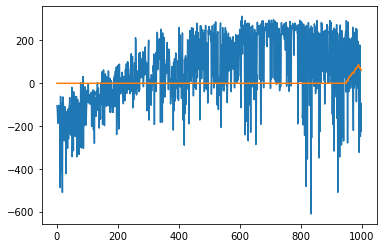

In [22]:
plt.plot(training_agent.rewards)
plt.plot(training_agent.moving_average)

[I 2022-06-12 22:01:46,357] A new study created in memory with name: no-name-eb36011f-f9de-44f6-b253-153428d9990a


The episode 1 total rewards is -257.92890228366923
The episode 11 total rewards is -127.07684855971345
The episode 21 total rewards is -391.1194038258198
The episode 31 total rewards is -228.0570674900716
The episode 41 total rewards is -122.43016885560566
The episode 51 total rewards is -386.9165278683204
The episode 61 total rewards is -319.44215308816035
The episode 71 total rewards is -35.42086237725613
The episode 81 total rewards is -109.6761235353246
The episode 91 total rewards is -60.87882010940865
The episode 101 total rewards is -219.23740342917264
The episode 111 total rewards is -74.3909092674826
The episode 121 total rewards is -5.705532270335283
The episode 131 total rewards is -165.1297574612692
The episode 141 total rewards is -76.22493373043018
The episode 151 total rewards is -174.16627508462122
The episode 161 total rewards is 72.42279704375073
The episode 171 total rewards is 49.64904718470949
The episode 181 total rewards is 21.113414967814382
The episode 191 tota

[I 2022-06-12 22:06:39,331] Trial 0 finished with value: -29.99549182288824 and parameters: {'DQL_nodes 1': 48, 'nodes_2': 45, 'dicount rate': 0.9783032937004372, 'lr': 0.000502586256733191, 'DQL nodes 2': 54, 'decay': 0.9933602260587918}. Best is trial 0 with value: -29.99549182288824.


The episode 1 total rewards is -242.14047645391224
The episode 11 total rewards is -96.02134826642487
The episode 21 total rewards is -131.1083963397374
The episode 31 total rewards is -157.3766723407089
The episode 41 total rewards is -115.52319736649063
The episode 51 total rewards is -65.10516296320682
The episode 61 total rewards is -172.7050514325747
The episode 71 total rewards is -153.9633908748865
The episode 81 total rewards is -182.9481175723144
The episode 91 total rewards is -76.65861940230687
The episode 101 total rewards is -221.7798107130646
The episode 111 total rewards is -161.43506754646856
The episode 121 total rewards is 103.26753139923105
The episode 131 total rewards is -187.83480063108826
The episode 141 total rewards is 36.23032762683923
The episode 151 total rewards is -81.88513789875897
The episode 161 total rewards is -69.79033658340974
The episode 171 total rewards is -107.83392852973236
The episode 181 total rewards is -105.51990110700473
The episode 191 to

[I 2022-06-12 22:07:32,804] Trial 1 finished with value: -99.70520742207957 and parameters: {'DQL_nodes 1': 96, 'nodes_2': 66, 'dicount rate': 0.9370978791284981, 'lr': 0.0008819628347575319, 'DQL nodes 2': 63, 'decay': 0.9987200264772003}. Best is trial 0 with value: -29.99549182288824.


The episode 1 total rewards is -118.84076448612475
The episode 11 total rewards is -30.048832734759856
The episode 21 total rewards is -258.8910951021716
The episode 31 total rewards is -186.5633227500574
The episode 41 total rewards is -250.26277293500098
The episode 51 total rewards is -86.8366262312989
The episode 61 total rewards is -208.25239753950783
The episode 71 total rewards is -229.74307820321445
The episode 81 total rewards is -281.3417966583273
The episode 91 total rewards is -368.08375156922665
The episode 101 total rewards is -96.04442395055457
The episode 111 total rewards is -198.46926237759632
The episode 121 total rewards is 18.235874631674875
The episode 131 total rewards is 106.78825113498769
The episode 141 total rewards is -225.24364891518263
The episode 151 total rewards is 58.04676089535188
The episode 161 total rewards is -160.44947398759143
The episode 171 total rewards is -35.396639320536536
The episode 181 total rewards is 25.198656447466117
The episode 191

[I 2022-06-12 22:12:07,828] Trial 2 finished with value: -28.12598937440493 and parameters: {'DQL_nodes 1': 34, 'nodes_2': 33, 'dicount rate': 0.9010952121615743, 'lr': 0.0005776518285238604, 'DQL nodes 2': 51, 'decay': 0.9906050684717242}. Best is trial 2 with value: -28.12598937440493.


The episode 1 total rewards is -248.8812737353379
The episode 11 total rewards is -189.79354456877493
The episode 21 total rewards is -207.02021018726646
The episode 31 total rewards is -195.10764487751268
The episode 41 total rewards is -65.20316259323408
The episode 51 total rewards is -144.98490126812396
The episode 61 total rewards is -57.194373538407
The episode 71 total rewards is -157.4786779819663
The episode 81 total rewards is -98.48646157024288
The episode 91 total rewards is -183.56198402882205
The episode 101 total rewards is -20.67067075827923
The episode 111 total rewards is 38.63655428898477
The episode 121 total rewards is 11.008286642639263
The episode 131 total rewards is -63.875490497050016
The episode 141 total rewards is -161.06686235607526
The episode 151 total rewards is 100.63889555270663
The episode 161 total rewards is 54.37035189439922
The episode 171 total rewards is 73.05151962415488
The episode 181 total rewards is 6.022259402713544
The episode 191 total 

[I 2022-06-12 22:16:46,968] Trial 3 finished with value: 41.82946896658695 and parameters: {'DQL_nodes 1': 46, 'nodes_2': 96, 'dicount rate': 0.9915670677042686, 'lr': 0.0009074084589674853, 'DQL nodes 2': 58, 'decay': 0.9942005887509291}. Best is trial 3 with value: 41.82946896658695.


The episode 1 total rewards is -204.80913664701438
The episode 11 total rewards is -156.0009112389271
The episode 21 total rewards is -68.69661597354194
The episode 31 total rewards is -330.6442446490594
The episode 41 total rewards is -80.02039248577776
The episode 51 total rewards is -77.59155110811218
The episode 61 total rewards is -261.61180158355273
The episode 71 total rewards is -422.63440737608283
The episode 81 total rewards is -149.26567097268085
The episode 91 total rewards is -158.5186877959187
The episode 101 total rewards is -89.53279422752964
The episode 111 total rewards is -301.72743365334986
The episode 121 total rewards is -93.89360150577662
The episode 131 total rewards is -98.2125845983281
The episode 141 total rewards is -100.64548183750995
The episode 151 total rewards is -175.2854198530402
The episode 161 total rewards is -76.25362422147404
The episode 171 total rewards is -218.03460672798596
The episode 181 total rewards is -104.8834703841826
The episode 191 t

[I 2022-06-12 22:17:32,755] Trial 4 finished with value: -120.84191837912216 and parameters: {'DQL_nodes 1': 37, 'nodes_2': 35, 'dicount rate': 0.9610071961820451, 'lr': 0.0006602756754233055, 'DQL nodes 2': 62, 'decay': 0.9988539795818744}. Best is trial 3 with value: 41.82946896658695.


The episode 1 total rewards is -100.19262856899421
The episode 11 total rewards is -322.88827562829124
The episode 21 total rewards is -434.34617949033935
The episode 31 total rewards is -401.8855499655979
The episode 41 total rewards is -245.35393582898004
The episode 51 total rewards is -321.14167226379993
The episode 61 total rewards is -210.98478942494546
The episode 71 total rewards is -177.56486434779117
The episode 81 total rewards is -255.2868039110522
The episode 91 total rewards is -66.8370197805145
The episode 101 total rewards is -42.13134429334145
The episode 111 total rewards is -204.86416812002392
The episode 121 total rewards is -2.486425917965306
The episode 131 total rewards is -55.3265115941852
The episode 141 total rewards is -135.31584121611695
The episode 151 total rewards is -44.353394331780244
The episode 161 total rewards is -59.7140324540089
The episode 171 total rewards is 63.29405789725937
The episode 181 total rewards is -27.34164518187319
The episode 191 t

[I 2022-06-12 22:20:41,976] Trial 5 finished with value: -41.019745802296164 and parameters: {'DQL_nodes 1': 49, 'nodes_2': 79, 'dicount rate': 0.9572936847858522, 'lr': 0.0006565298716658261, 'DQL nodes 2': 32, 'decay': 0.9956080725479213}. Best is trial 3 with value: 41.82946896658695.


The episode 1 total rewards is -325.639409699011
The episode 11 total rewards is -346.54936249396303
The episode 21 total rewards is -134.62079112097672
The episode 31 total rewards is -33.04240742127993
The episode 41 total rewards is -270.21451488600894
The episode 51 total rewards is -178.0780565137514
The episode 61 total rewards is -179.5482366669986
The episode 71 total rewards is -195.18538591730908
The episode 81 total rewards is -104.67151049054483
The episode 91 total rewards is -62.79261311001281
The episode 101 total rewards is -104.74160340864799
The episode 111 total rewards is -53.19956528336384
The episode 121 total rewards is -82.94282307094386
The episode 131 total rewards is -51.14817011429786
The episode 141 total rewards is -148.31430421438736
The episode 151 total rewards is -93.89670250559861
The episode 161 total rewards is -65.82731059773099
The episode 171 total rewards is 20.019350262700172
The episode 181 total rewards is -83.32218472818609


KeyboardInterrupt: 

In [88]:
print(training_agent.agent.eps)
training_agent.test_agent(env,render=True)


0.05
The episode total rewards is  199.85354865513972
